In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class_sets = list()

# mass images and roi
s1 = 'data/CBIS-DDSM/processed/whole/whole_images/test/BENIGN_Mass'
r1 = 'data/CBIS-DDSM/processed/whole/roi_images/test/BENIGN_Mass'
dsts1 = 'data/CBIS-DDSM/processed/cropped/images/test/BENIGN_Mass'
dstr1 = 'data/CBIS-DDSM/processed/cropped/roi/test/BENIGN_Mass'

s2 = 'data/CBIS-DDSM/processed/whole/whole_images/test/MALIGNANT_Mass'
r2 = 'data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Mass'
dsts2 = 'data/CBIS-DDSM/processed/cropped/images/test/MALIGNANT_Mass'
dstr2 = 'data/CBIS-DDSM/processed/cropped/roi/test/MALIGNANT_Mass'

# calcification data and roi
s3 = 'data/CBIS-DDSM/processed/whole/whole_images/test/MALIGNANT_Calc'
r3 = 'data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc'
dsts3 = 'data/CBIS-DDSM/processed/cropped/images/test/MALIGNANT_Calc'
dstr3 = 'data/CBIS-DDSM/processed/cropped/roi/test/MALIGNANT_Calc'

s4 = 'data/CBIS-DDSM/processed/whole/whole_images/test/BENIGN_Calc'
r4 = 'data/CBIS-DDSM/processed/whole/roi_images/test/BENIGN_Calc'
dsts4 = 'data/CBIS-DDSM/processed/cropped/images/test/BENIGN_Calc'
dstr4 = 'data/CBIS-DDSM/processed/cropped/roi/test/BENIGN_Calc'

class_sets.append([s1, r1, dsts1, dstr1])
class_sets.append([s2, r2, dsts2, dstr2])
class_sets.append([s3, r3, dsts3, dstr3])
class_sets.append([s4, r4, dsts4, dstr4])

In [3]:
'''
1. Pick cropping window size
2. Apply non-max suppression on mask
3. Using the non-zero point in the mask as the center, crop the image
4. Use the same point to crop the original mask
5. Save images
'''

def apply_nonmax_sup(mask):
    
    # get a list on all indices with max values
    x_idxs = np.where(mask == 255)[1]
    y_idxs = np.where(mask == 255)[0]
    
    # get center coordinates
    x = np.median(x_idxs)
    y = np.median(y_idxs)
    
    return int(x), int(y)
    

def get_cropped_images(img, mask, center_x, center_y):
    
    # height and width for crop window
    h = 950
    w = 950
    
    # Calculate coordinates for cropping
    top_left_x = int(center_x - (w / 2))
    top_left_y = int(center_y - (h / 2))
    bottom_right_x = top_left_x + w
    bottom_right_y = top_left_y + h
    
    # check if crop window exceeds image dimensions  
    if top_left_x < 0:
        top_left_x = 0
        
    if top_left_y < 0:
        top_left_y = 0
    
    if bottom_right_x >= img.shape[1]:
        bottom_right_x = img.shape[1] - 1
        
    if bottom_right_y >= img.shape[0]:
        bottom_right_y = img.shape[0] - 1 
    
    # Crop the image
    cropped_image = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    cropped_mask = mask[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    return cropped_image, cropped_mask
        

In [145]:
single_img_path = 'data/CBIS-DDSM/processed/whole/whole_images/train/BENIGN_Mass/1103_R_CC.jpeg'
single_roi_path = 'data/CBIS-DDSM/processed/whole/roi_images/train/BENIGN_Mass/1103_R_CC.jpeg'

In [146]:
os.listdir('data/CBIS-DDSM/processed/whole/whole_images/train/BENIGN_Mass')[0]

'1039_R_CC.jpeg'

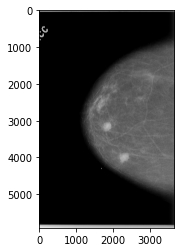

In [147]:
# read image
im1 = cv2.imread(single_img_path)
plt.imshow(im1)

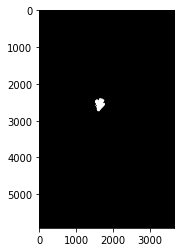

In [148]:
m2 = cv2.imread(single_roi_path)
m2 = cv2.cvtColor(m2, cv2.COLOR_BGR2GRAY)
plt.imshow(m2, cmap = 'gray')

In [149]:
# get center coordinates
c_x, c_y = apply_nonmax_sup(m2)

In [150]:
# get and display cropped images
c_img1, c_mask1 = get_cropped_images(im1, m2, c_x, c_y)

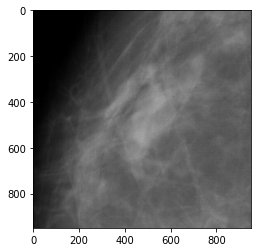

In [151]:
plt.imshow(c_img1, cmap = 'gray')

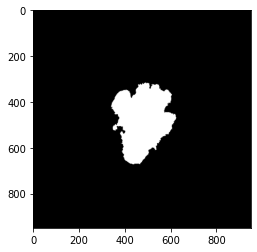

In [152]:
plt.imshow(c_mask1, cmap = 'gray')

In [5]:
def create_patch_data(img_folder, mask_folder, cropped_img_folder, cropped_roi_folder):
    
    # read image names
    image_files = os.listdir(img_folder)
    
    # for each image
    for image_name in image_files:
        # get image path
        image_path = os.path.join(img_folder, image_name)
        mask_path = os.path.join(mask_folder, image_name)
        
        # if mask exists
        if os.path.exists(mask_path):
            
            # read image and masks
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            
            # apply non-max suppression and get center 
            center_x, center_y = apply_nonmax_sup(mask)

            # get cropped images
            cropped_img, cropped_mask = get_cropped_images(img, mask, center_x, center_y)

            # save images
            cp_img_dst_path = os.path.join(cropped_img_folder, image_name)
            cp_roi_dst_path = os.path.join(cropped_roi_folder, image_name)
            cv2.imwrite(cp_img_dst_path, cropped_img)
            cv2.imwrite(cp_roi_dst_path, cropped_mask)
                
        else:
            print(f'Mask file {mask_path} does not exist.')
          
    print(f'FINISHED SAVING IMAGES FROM {img_folder}.\n')

In [6]:
for class_type in class_sets:
    create_patch_data(class_type[0], class_type[1], class_type[2], class_type[3])

FINISHED SAVING IMAGES FROM data/CBIS-DDSM/processed/whole/whole_images/test/BENIGN_Mass.

FINISHED SAVING IMAGES FROM data/CBIS-DDSM/processed/whole/whole_images/test/MALIGNANT_Mass.

Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1067_L_CC.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1179_L_MLO.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1217_R_MLO.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1253_R_MLO.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1483_L_CC.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1635_R_MLO.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1670_L_MLO.jpeg does not exist.
Mask file data/CBIS-DDSM/processed/whole/roi_images/test/MALIGNANT_Calc\1803_R_CC.jpeg do